In [ ]:
import numpy as np
import random
import gym
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')

In [ ]:
env =gym.make("Taxi-v3")
env.reset()

# Current State
print(env.s)

# Primitive Actions
action = ["south", "north", "east", "west","pickup","dropoff","option_B","option_Y","option_R","option_G"]

# Example Transitions
rnd_action = random.randint(0,5)
print ("ACTION TAKEN:", action[rnd_action])
next_state, reward, is_terminal, t_prob = env.step(rnd_action)
print ("TRANSITION PROB:", t_prob)
print ("NEXT STATE:", next_state)
print ("REWARD:", reward)
print ("TERMINAL STATE:", is_terminal)
env.s = next_state

63
ACTION TAKEN: west
TRANSITION PROB: {'prob': 1.0, 'action_mask': array([1, 0, 1, 0, 0, 0], dtype=int8)}
NEXT STATE: 43
REWARD: -1
TERMINAL STATE: False


In [ ]:
#pax_locations = [(0, 0), (0, 4), (4, 0), (4, 3)]
option_R= [[1,3,0,0,0], [1,3,0,0,0],[1,3,3,3,3],[1,1,1,1,1],[1,1,1,1,1]]
option_B= [[0,0,0,0,0], [0,0,0,0,0],[2,2,2,0,3],[1,1,1,0,3],[1,1,1,0,3]]
option_Y= [[0,0,0,0,0], [0,0,0,0,0],[0,3,3,3,3],[0,1,1,1,1],[3,1,1,1,1]]
option_G= [[0,0,2,2,2], [0,0,2,2,1],[2,2,2,2,1],[1,1,1,1,1],[1,1,1,1,1]]

In [ ]:
from scipy.special import softmax

seed=42
rg = np.random.RandomState(seed)

def egreedy_policy(q_values,state,epsilon):
    rnd=rg.rand()
    if  rnd< epsilon:
        return  rg.choice(q_values.shape[-1])
    else:
        return np.argmax(q_values[state])

def softmax_policy(q_values,state,tau=0.9):
    rnd=rg.rand()
    x=softmax(q_values[state]/tau)
    return np.argmax(x)

In [ ]:
def reach_B(state):
    taxi_row, taxi_col, passenger_index, destination_index = get_state_info(state)
    option_done = False
    reached_goal = False
    if taxi_row == 4 and taxi_col == 3:
        option_done = True
        if passenger_index == 3:
            action = 4  # pick up
        elif destination_index == 3 and passenger_index == 4:
            action = 5  # drop off
            reached_goal = True
        else:
            action = option_B[taxi_row][taxi_col]
    else:
        action = option_B[taxi_row][taxi_col]

    return [action, option_done, reached_goal]

def reach_G(state):
    taxi_row, taxi_col, passenger_index, destination_index = get_state_info(state)
    option_done = False
    reached_goal = False
    if taxi_row == 0 and taxi_col == 4:
        if passenger_index == 1:
            action = 4  # pick up
        elif destination_index == 1 and passenger_index == 4:
            action = 5  # drop off
            reached_goal = True
        else:
            action = option_G[taxi_row][taxi_col]
        option_done = True
    else:
        action = option_G[taxi_row][taxi_col]

    return [action, option_done, reached_goal]


def reach_R(state):
    taxi_row, taxi_col, passenger_index, destination_index = get_state_info(state)
    option_done = False
    reached_goal = False
    if taxi_row == 0 and taxi_col == 0:
        if passenger_index == 0:
            action = 4  # pick up
        elif destination_index == 0 and passenger_index == 4:
            action = 5  # drop off
            reached_goal = True
        else:
            action = option_R[taxi_row][taxi_col]
        option_done = True

    else:
        action = option_R[taxi_row][taxi_col]

    return [action, option_done, reached_goal]


def reach_Y(state):
    taxi_row, taxi_col, passenger_index, destination_index = get_state_info(state)
    option_done = False
    reached_goal = False
    if taxi_row == 4 and taxi_col == 0:
        option_done = True
        if passenger_index == 2:
            action = 4  # pick up
        elif destination_index == 2 and passenger_index == 4:
            action = 5  # drop off
            reached_goal = True
        else:
            action = option_Y[taxi_row][taxi_col]

    else:
        action = option_Y[taxi_row][taxi_col]

    return [action, option_done, reached_goal]

def get_state_info(state):
    pick_drop = state % 20
    position = state // 20
    y_position = position // 5
    x_position = position % 5
    drop = pick_drop % 4
    passenger = pick_drop // 4
    return y_position, x_position, passenger, drop

In [ ]:
actions = [0,1,2,3,4,5,6,7,8,9]

## SMDP Q Learning

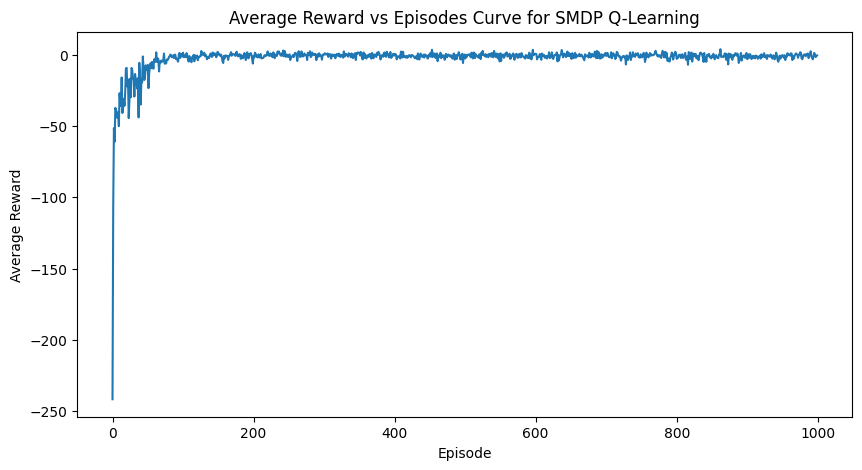

In [ ]:
from tqdm import tqdm
from IPython.display import clear_output

#### SMDP Q-Learning
actions = [0, 1, 2, 3, 4, 5, reach_R, reach_G, reach_Y, reach_B]
num_states = 500
num_actions = len(actions)

# Q-Table: (States x Actions) === (env.num_states x total_actions)
q_values_SMDP = np.zeros((num_states, num_actions))
state_visits = np.zeros(num_states)
action_visits = np.zeros((num_states, num_actions))
steps_per_episode = []
rewards_per_episode = []
avg_rewards_per_episode = []

# Add parameters you might need here
gamma = 0.9
alpha = 0.9

for episode in range(10000):
    state = env.reset()
    done = False
    episode_steps = 0
    episode_reward = 0

    while not done:
        # Choose action
        action = egreedy_policy(q_values_SMDP, state, epsilon=0.1)

        if action < 6:
            episode_steps += 1
            state_next, reward, done, _ = env.step(action)
            action_next = np.argmax(q_values_SMDP[state_next])
            q_values_SMDP[state, action] += alpha * (reward + gamma * q_values_SMDP[state_next, action_next] - q_values_SMDP[state, action])
            action_visits[state, action] += 1
            state_visits[state] += 1
            state = state_next
            episode_reward += reward

        reward_bar = 0
        if action >= 6:
            option_done = False
            cnt = 0
            old_state = state

            while not option_done:
                opt_action, option_done, reached_goal = actions[action](state)
                next_state, reward, done, _ = env.step(opt_action)
                reward_bar = gamma ** cnt * reward + reward_bar
                action_next = np.argmax(q_values_SMDP[next_state])

                if option_done:
                    q_values_SMDP[old_state, action] += alpha * (reward_bar + (gamma ** cnt) * q_values_SMDP[next_state, action_next] - q_values_SMDP[old_state, action])
                    action_visits[old_state, action] += 1
                    state_visits[old_state] += 1
                    episode_reward += reward_bar

                cnt += 1
                state = next_state

    rewards_per_episode.append(episode_reward)
    steps_per_episode.append(episode_steps)

    if episode % 10 == 0:
        avg_rewards_per_episode.append(np.mean(rewards_per_episode[-10:]))

# Average Reward vs Num_Episodes curve
plt.figure(figsize=(10,5))
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.plot([i for i in range(len(avg_rewards_per_episode))], avg_rewards_per_episode)
plt.title("Average Reward vs Episodes Curve for SMDP Q-Learning")
plt.show()

In [ ]:
location_names = {0: 'Red', 1: 'Green', 2: 'Yellow', 3: 'Blue', 4: 'Taxi'}
action_names = {0: 'S', 1: 'N', 2: 'E', 3: 'W', 4: 'P', 5: 'D', 6: 'R', 7: 'G', 8: 'Y', 9: 'B'}

def extract_Q_matrix(q_values, passenger_loc, destination_loc):
    Q_matrix = np.zeros((5, 5, 10))
    for row in range(5):
        for col in range(5):
            Q_matrix[row][col][:] = np.copy(q_values[env.encode(row, col, passenger_loc, destination_loc)])
    return Q_matrix

DOWN  = 0
UP    = 1
LEFT  = 2
RIGHT = 3

def plot_policy(q_values):
    fig, axs = plt.subplots(5, 4, figsize=(50,50))
    for passenger_loc in range(5):
        for destination_loc in range(4):
            if passenger_loc == destination_loc:
                continue
            Q = extract_Q_matrix(q_values, passenger_loc, destination_loc)
            axs[passenger_loc, destination_loc].set_title(f"Passenger at {location_names[passenger_loc].upper()} going to {location_names[destination_loc].upper()}")
            axs[passenger_loc, destination_loc].invert_yaxis()

            axs[passenger_loc, destination_loc].pcolor(Q.max(-1), edgecolors='k', linewidths=2)

            def x_direction(action):
                if action == RIGHT: return 1
                if action == LEFT: return -1
                return 0

            def y_direction(action):
                if action == UP: return 1
                if action == DOWN: return -1
                return 0

            policy = Q.argmax(-1)
            policy_x = np.vectorize(x_direction)(policy)
            policy_y = np.vectorize(y_direction)(policy)
            idx = np.indices(policy.shape)
            axs[passenger_loc, destination_loc].quiver(idx[1].ravel()+0.5, idx[0].ravel()+0.5, policy_x.ravel(), policy_y.ravel(), pivot="middle", color='red')
            for k in range(25):
                action = policy.reshape(25,)[k]
                if action < 4: continue
                axs[passenger_loc, destination_loc].annotate(f'{action_names[action]}', xy=(idx[1].ravel()[k]+0.5,idx[0].ravel()[k]+0.5), fontsize=20, ha='center', va='center')
    plt.show()

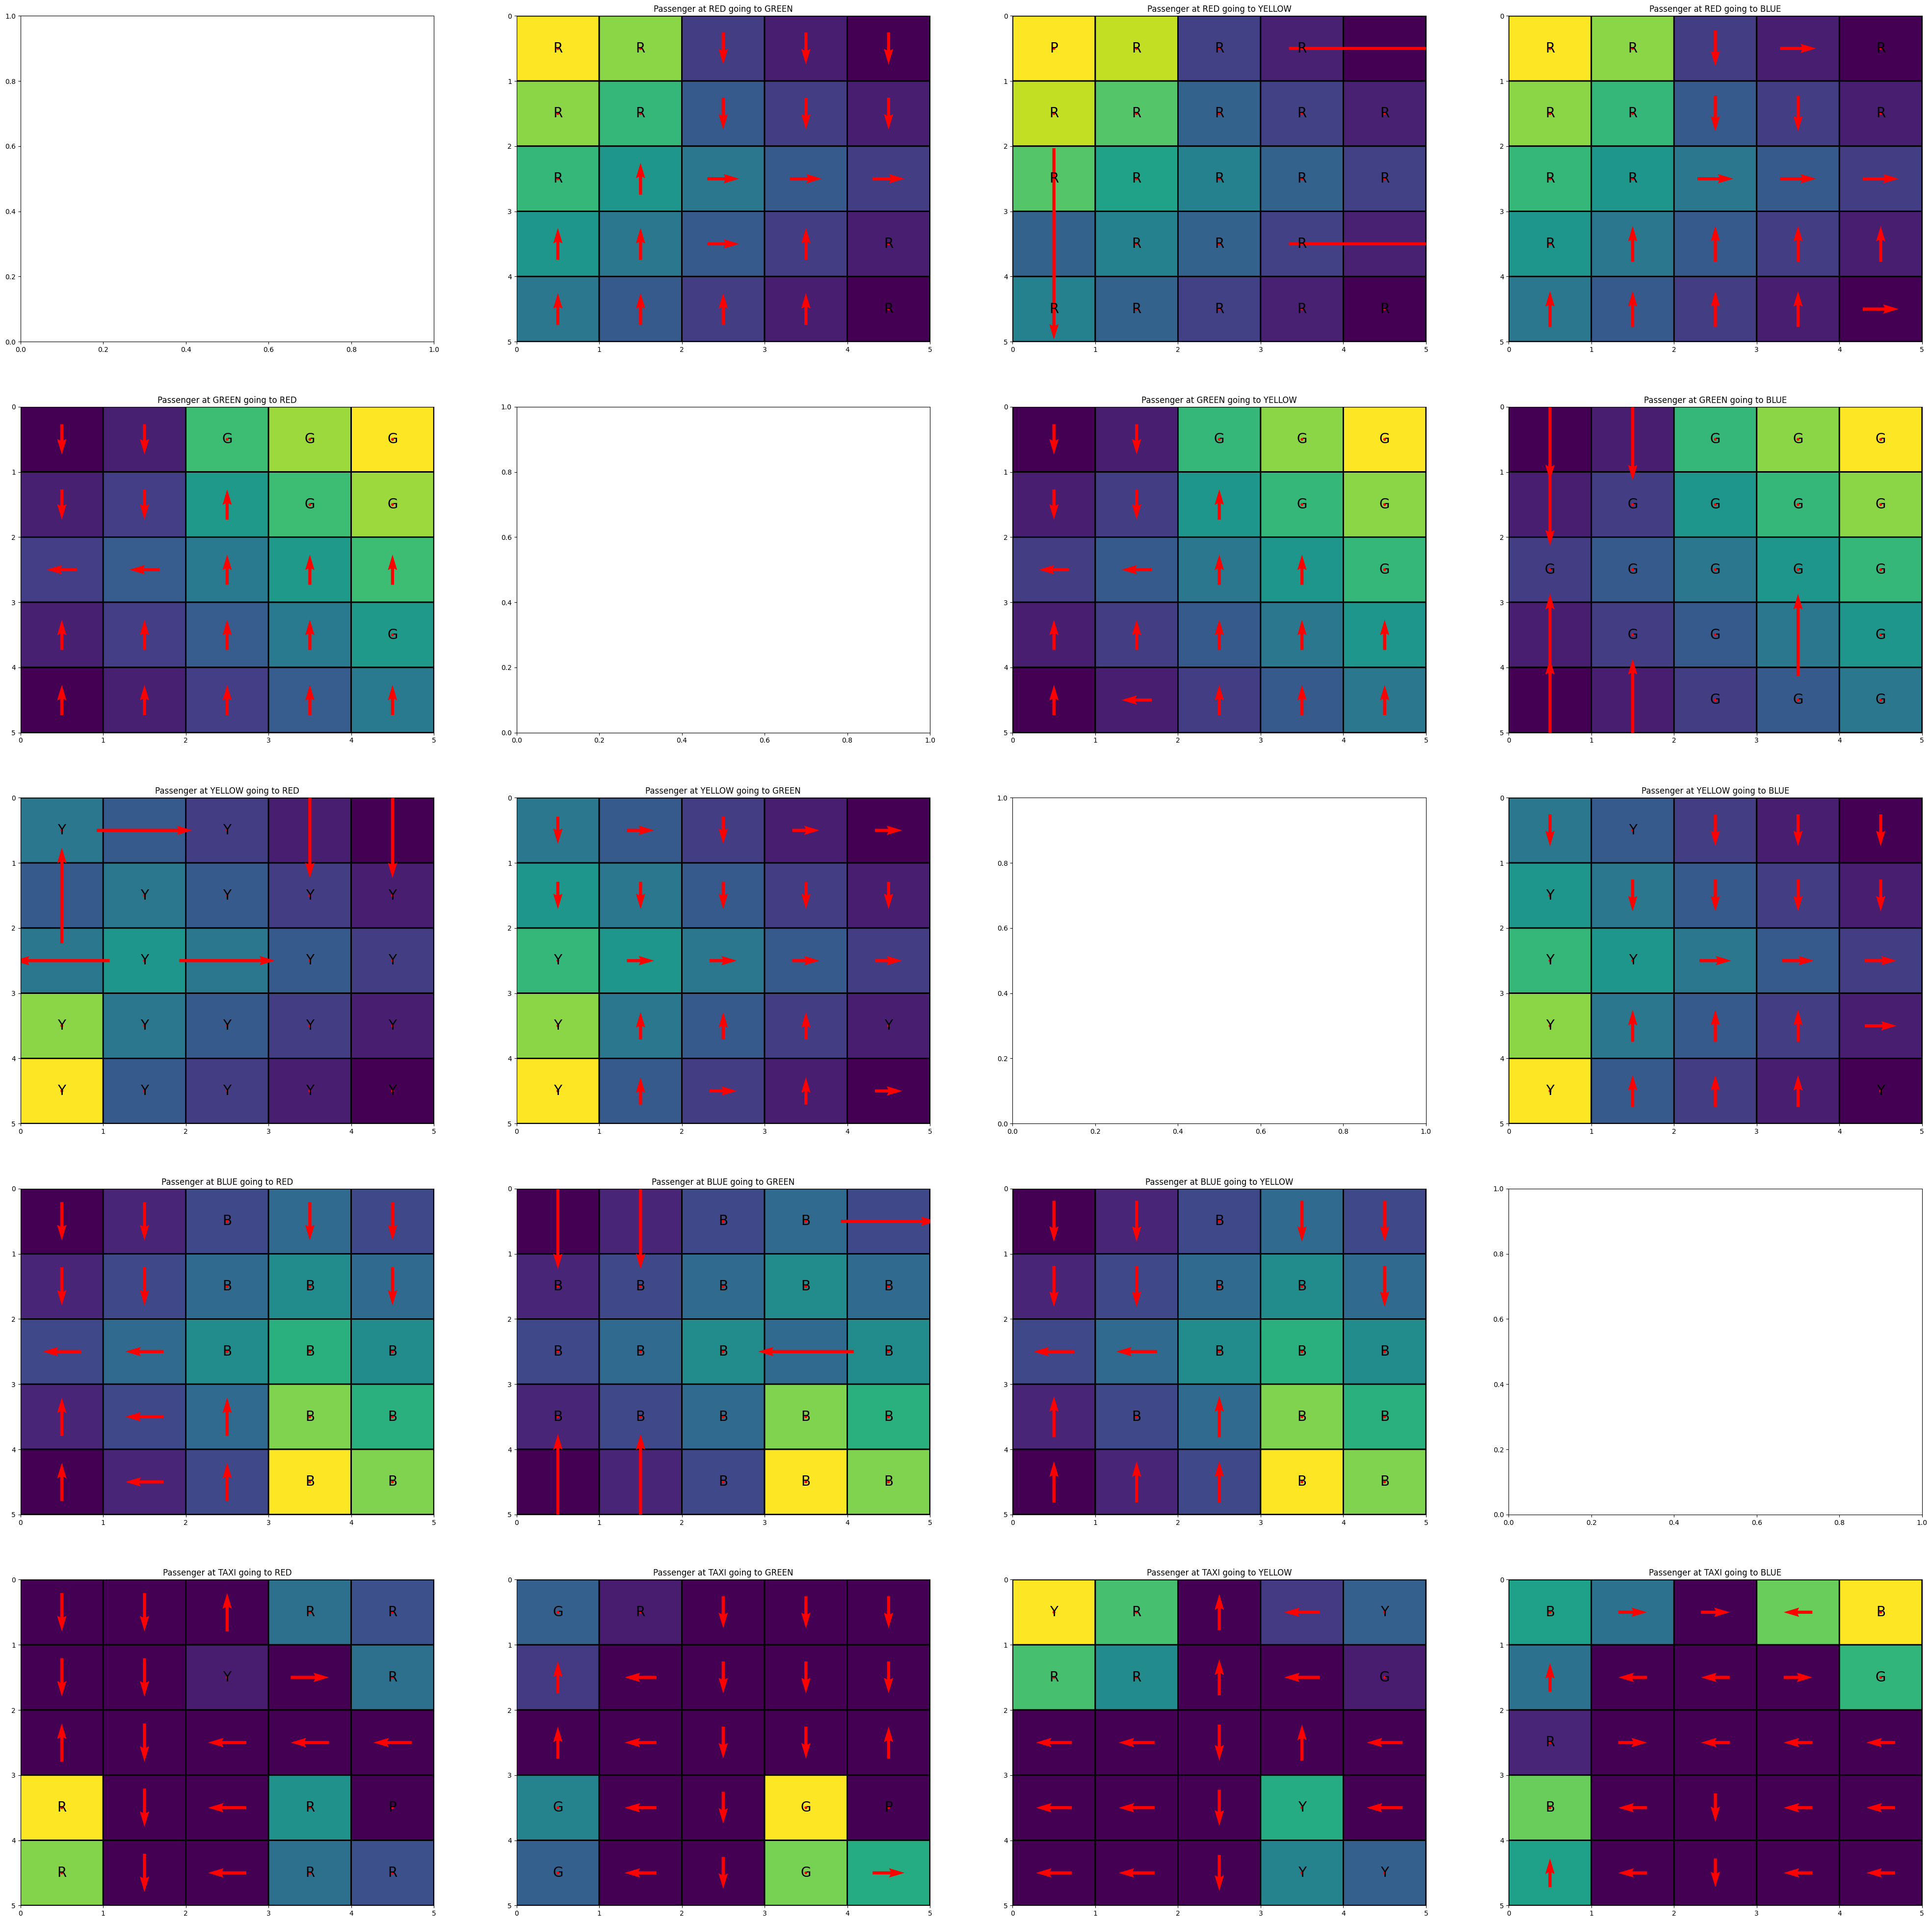

In [ ]:
plot_policy(q_values_SMDP)

## Intra-Option Q Learning

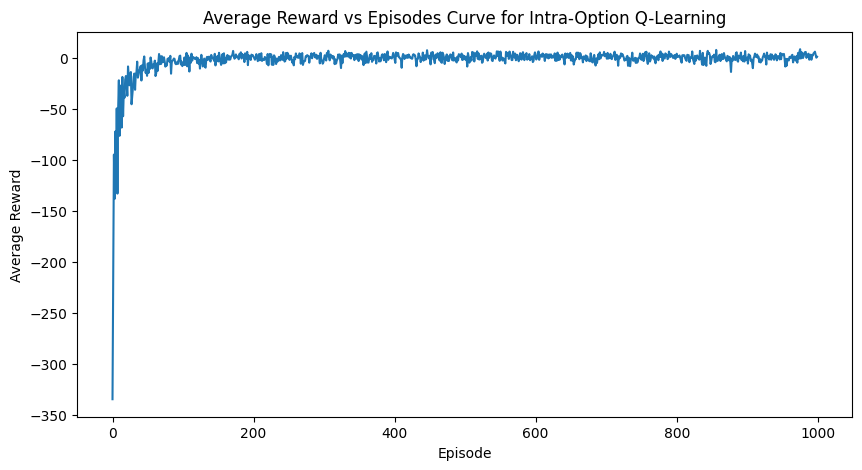

In [ ]:
q_values_intra_option = np.zeros((500, 10))
frequency_intra_option = np.zeros((500, 10))
steps_per_episode_intra = []
rewards_per_episode_intra = []
average_rewards_per_episode_intra = []

gamma = 0.9
alpha = 0.4

for episode in range(10000):
    state = env.reset()
    done = False
    episode_reward = 0
    episode_steps = 0

    # While episode is not over
    while not done:

        # Choose action
        action = egreedy_policy(q_values_intra_option, state, epsilon=0.1)

        # Checking if primitive action
        if action < 6:
            # Perform regular Q-Learning update for state-action pair
            next_state, reward, done, info = env.step(action)
            q_values_intra_option[state][action] = (1 - alpha) * (q_values_intra_option[state][action]) + (alpha) * (reward + gamma * (np.max(q_values_intra_option[next_state])))
            frequency_intra_option[state, action] += 1
            state = next_state
            episode_steps += 1
            episode_reward += reward

        # Checking if action chosen is an option
        else:
            initial_state = np.copy(state)
            option_done = False
            cnt = 0

            while not option_done:
                # Execute the option
                option_action, option_done, reached_goal = actions[action](state)

                next_state, reward, done, info = env.step(option_action)
                episode_reward += reward
                episode_steps += 1

                # Update Q-values using intra-option Q-learning
                q_values_intra_option[state, option_action] += alpha * (reward + gamma * np.max(q_values_intra_option[next_state]) - q_values_intra_option[state, option_action])
                frequency_intra_option[state, action] += 1

                # Calculate beta
                beta = int(option_done)

                # Calculate U(s', a)
                U_s_a = (1 - beta) * (q_values_intra_option[next_state, action]) + beta * (np.max(q_values_intra_option[next_state]))

                # Update Q-values
                q_values_intra_option[state, action] = (1 - alpha) * (q_values_intra_option[state, action]) + alpha * (reward + gamma * (U_s_a))
                frequency_intra_option[state, action] += 1

                state = next_state

    steps_per_episode_intra.append(episode_steps)
    rewards_per_episode_intra.append(episode_reward)

    if episode % 10 == 0:
        average_rewards_per_episode_intra.append(np.mean(rewards_per_episode_intra[-10:]))

# Average Reward vs Num_Episodes curve
plt.figure(figsize=(10,5))
plt.xlabel('Episode')
plt.ylabel('Average Reward')
plt.plot([i for i in range(len(average_rewards_per_episode_intra))], average_rewards_per_episode_intra)
plt.title("Average Reward vs Episodes Curve for Intra-Option Q-Learning")
plt.show()


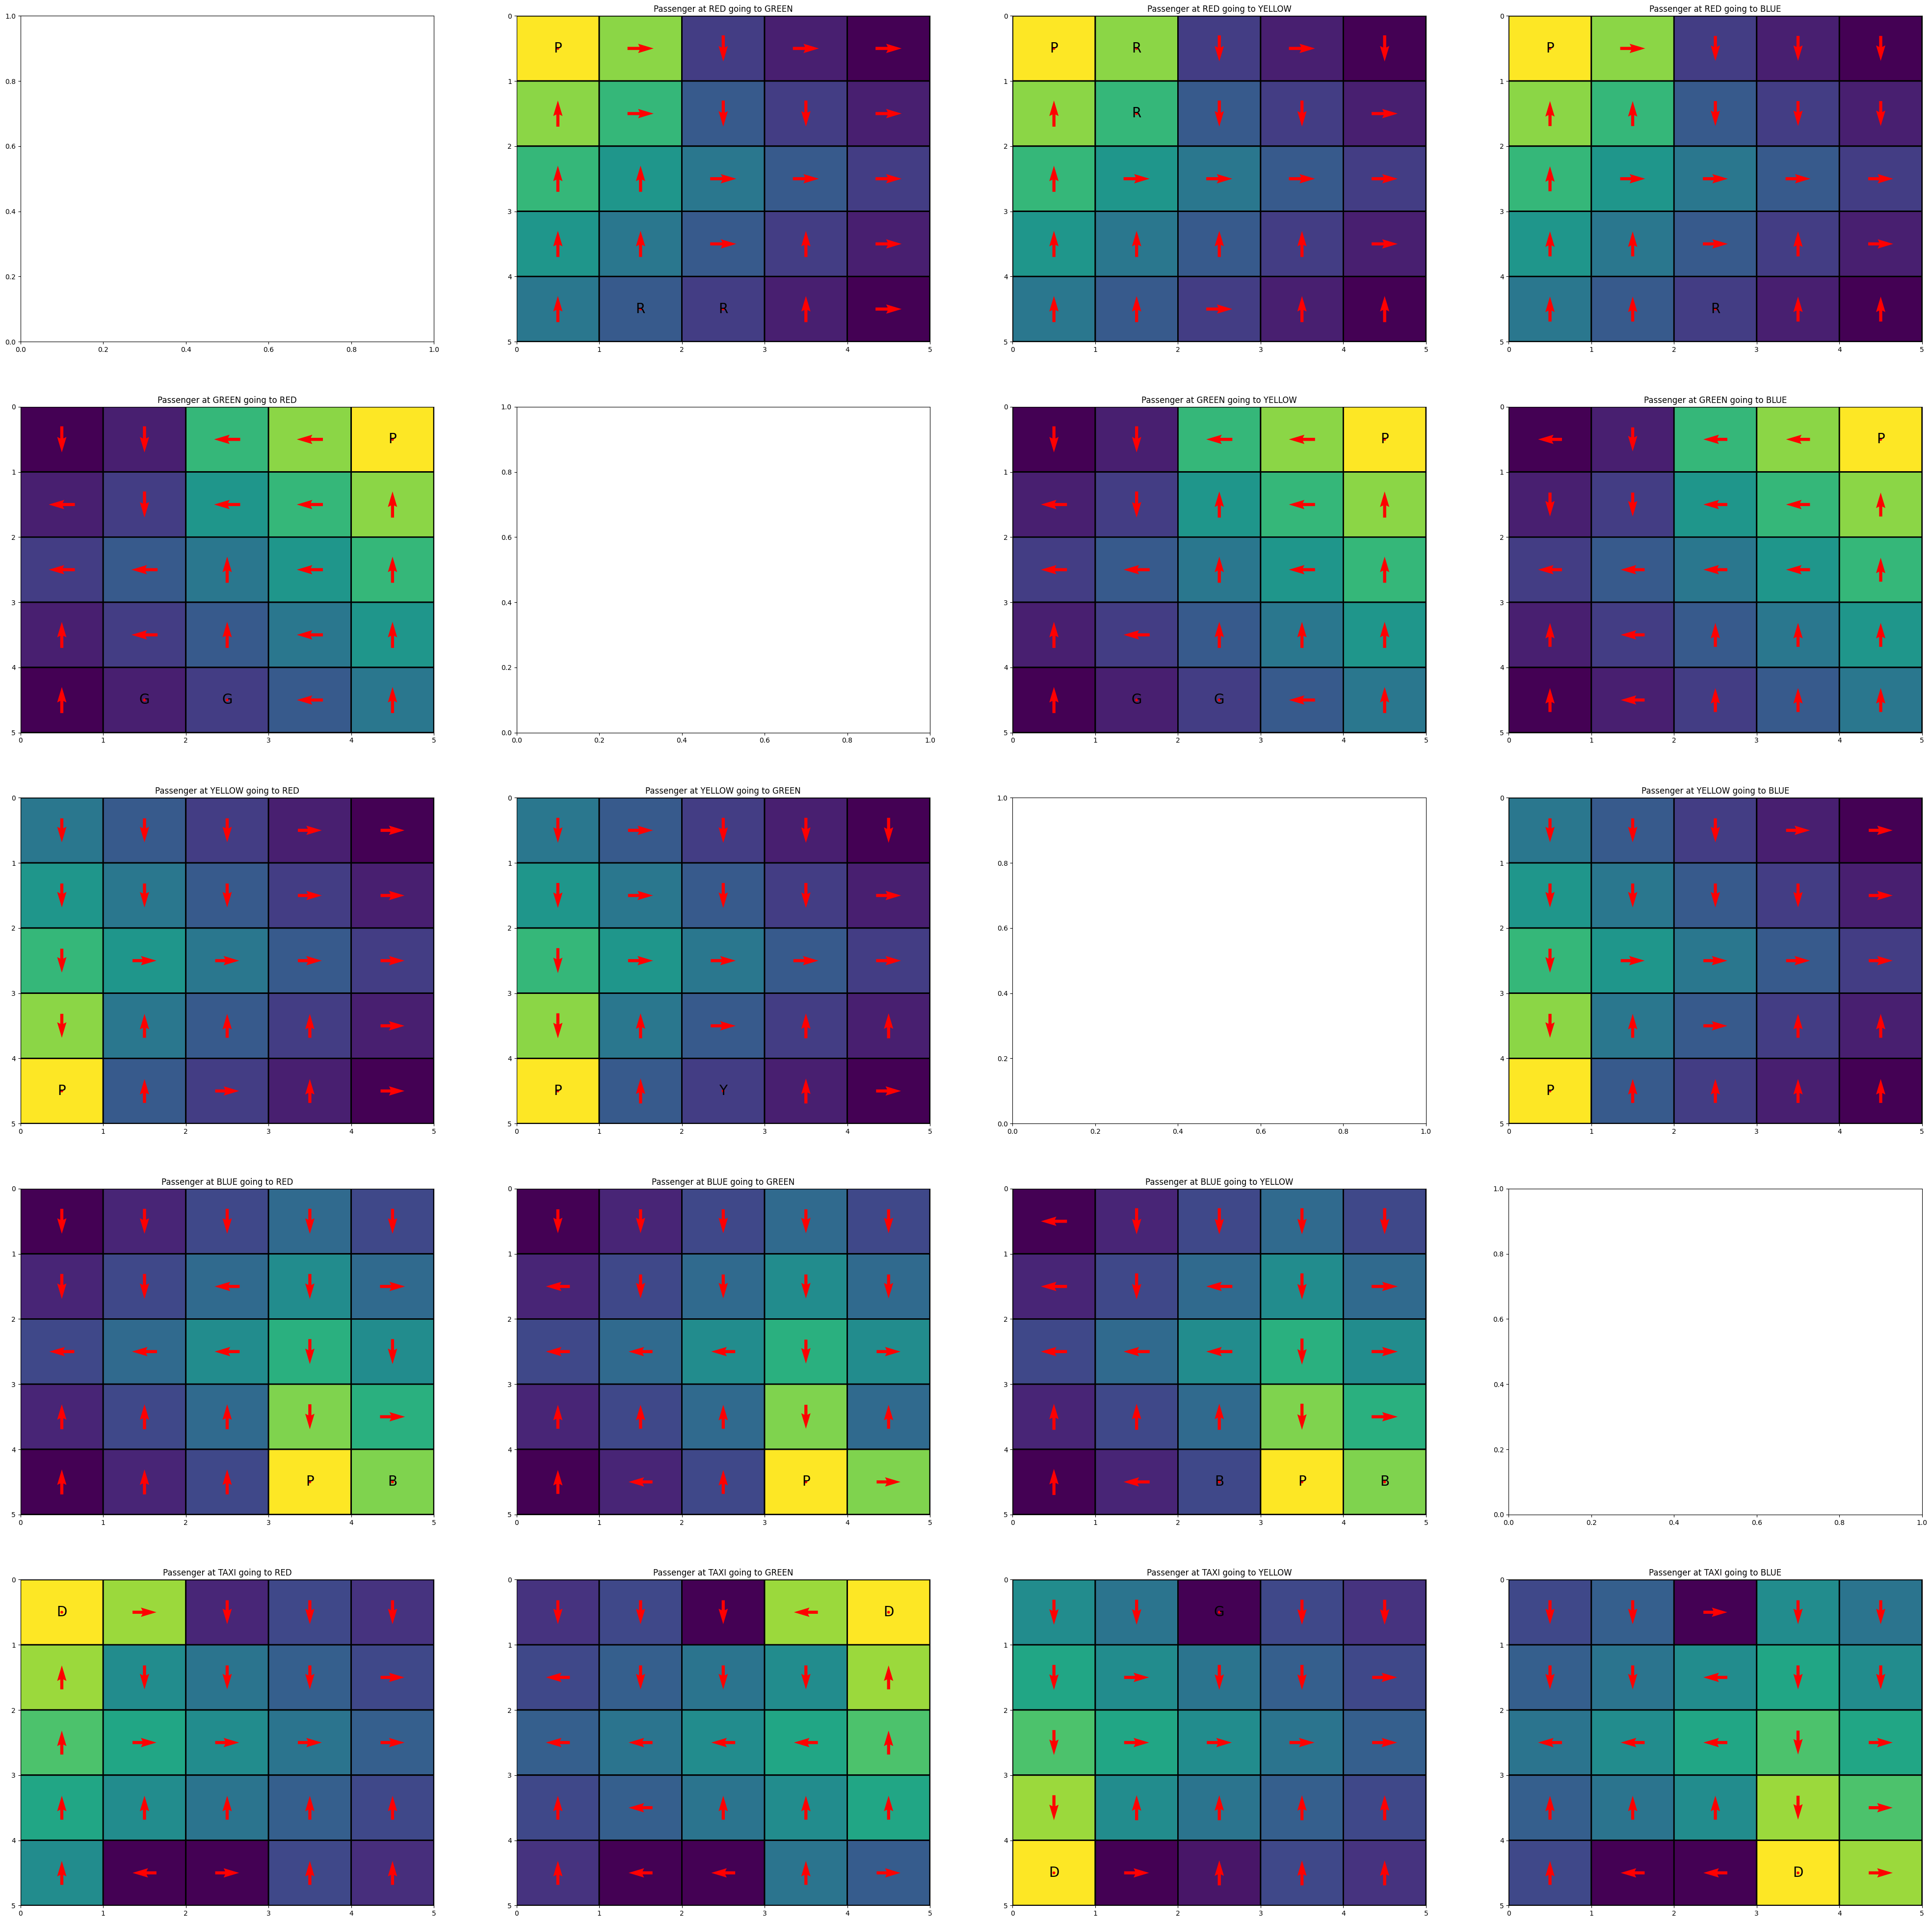

In [ ]:
plot_policy(q_values_intra_option)